In [1]:
import os
import cv2
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras.layers import Dense, Dropout, Conv2D, Flatten, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.optimizers import Adam
import scipy
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# set data directory
train_dir='train'
test_dir='test'

In [3]:
# Using image data generator to load images from directory
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


train_data = train_generator.flow_from_directory(
    directory=train_dir,
    subset='training',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    batch_size=256,
    seed=42
)

Found 35491 images belonging to 22 classes.


In [4]:
val_data = train_generator.flow_from_directory(
    directory=train_dir,
    subset='validation',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    batch_size=256
)

Found 8863 images belonging to 22 classes.


In [5]:
test_generator = ImageDataGenerator(rescale=1./255)

test_data = test_generator.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=256,
    shuffle=False
)

Found 11165 images belonging to 22 classes.


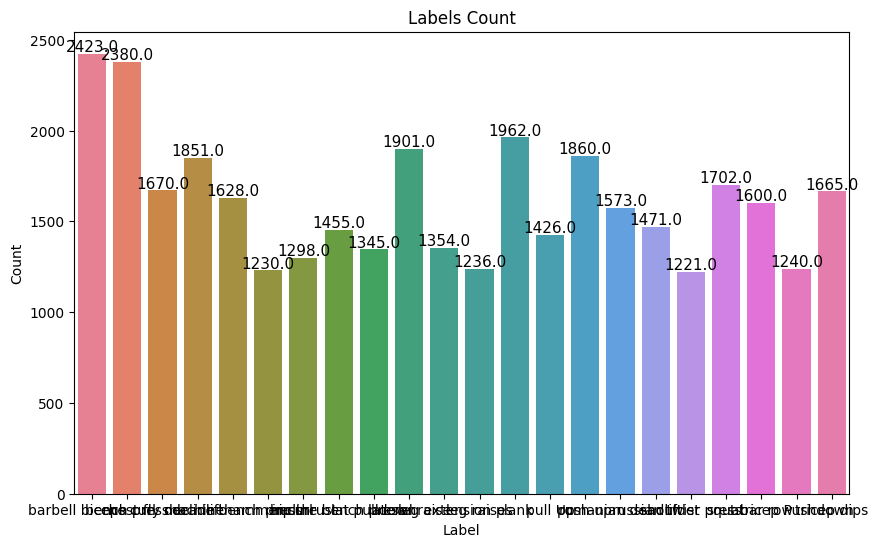

In [6]:
# Get the label counts
label_counts = train_data.classes

# Convert label counts array to DataFrame
label_counts_df = pd.DataFrame(label_counts, columns=['label'])

# Map label indices to label names
label_names = {v: k for k, v in train_data.class_indices.items()}
label_counts_df['label'] = label_counts_df['label'].map(label_names)

# Plot the countplot vertically
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='label', data=label_counts_df, orient='v', palette='husl')
plt.title('Labels Count')
plt.xlabel('Label')
plt.ylabel('Count')

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points', rotation=0)

plt.show()

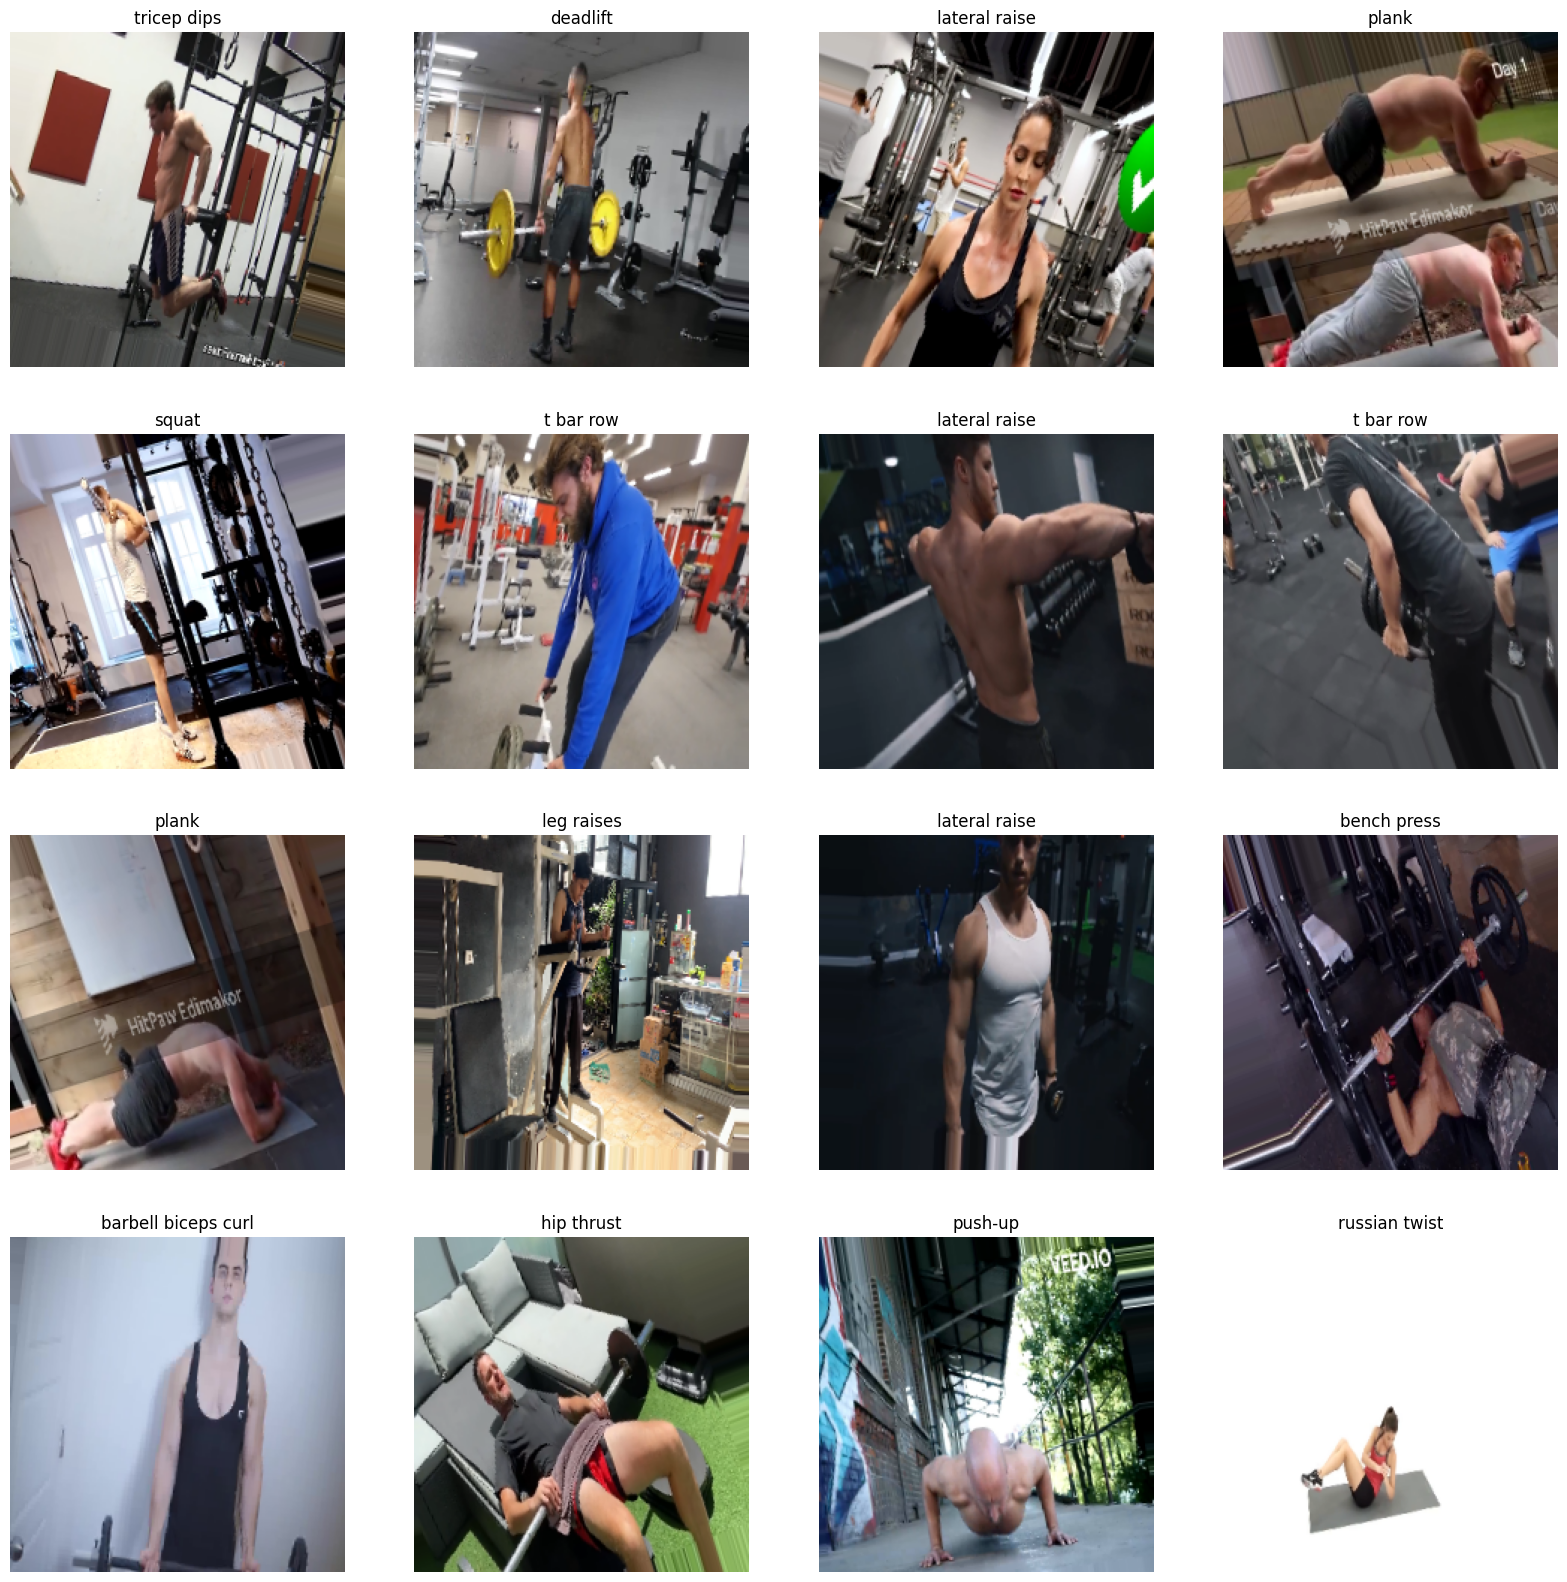

In [8]:
# To display a grid of images
plt.figure(figsize=(20, 20))

# Loop to print each image
for index, (images, labels) in enumerate(train_data):
    if index == 16:
        break  # Break after displaying 16 batches of images
    for i in range(len(images)):
        # Calculate subplot index directly based on current and total images
        subplot_index = (index * len(images) + i) % 16 + 1 
        plt.subplot(4, 4, subplot_index)
        img = images[i]
        # Get the index of the label
        label_index = np.argmax(labels[i])  # Assuming labels are one-hot encoded
        label_name = list(train_data.class_indices.keys())[label_index]  # Get the corresponding label name
        # Ensure image data type is uint8 and values are within [0, 255]
        img = (img * 255).astype('uint8')
        plt.imshow(img)  # Display the image
        plt.title(label_name)  # Display the label name
        plt.axis('off')

plt.show()


In [7]:
# Calculate class weights for over-sampling
classes = np.unique(train_data.classes)  # Extract unique classes
class_weights = compute_class_weight('balanced', classes=classes, y=train_data.classes)

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

In [8]:
def create_incept_model():

    incept = InceptionV3(input_shape=(224,224,3), include_top=False, weights='imagenet')  # Use the pre-trained CNN model (InceptionV3)
    
    print(len(incept.layers))                                                             # Print the number of layers in the InceptionV3 model
    
    for layer in incept.layers:                                                           # Set all layers in the InceptionV3 model to non-trainable
        layer.trainable = False
    pool=GlobalAveragePooling2D()(incept.output) 
    norm=BatchNormalization()(pool)
    flatten = Flatten()(norm)                                                 # Flatten the output of the InceptionV3 model
    drop=Dropout(0.4)(flatten)
    layer1 = Dense(units=256, activation='relu')(drop)                                  # Add a dense layer with 10 units and ReLU activation
    drop=Dropout(0.2)(layer1)
    layer2 = Dense(units=256, activation='relu')(drop)                                  # Add another dense layer with 2048 units and ReLU activation
    drop=Dropout(0.2)(layer2)
    layer3 = Dense(units=128, activation='relu')(drop)                                  # Add another dense layer with 2048 units and ReLU activation
    drop=Dropout(0.2)(layer3)
    output_layer=Dense(units=22, activation='softmax')(drop)     
    
    model = Model(incept.input, output_layer)                                                   # Create a model that maps input images to the output of the second dense layer
    # compile the model
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model    


In [9]:
model = create_incept_model()               # Get the feature encoder model using the defined function

print(len(model.layers))                     # Print the number of layers in the feature encoder model

model.summary()                              # Display a summary of the feature encoder model, showing its architecture and parameters

311
322
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                     

In [10]:
# set callbacks 
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0.001,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
checkpoint = ModelCheckpoint('model_weights.keras', monitor='val_loss', save_best_only=True, verbose=1)

callbacks = [earlystop, reduce_lr,checkpoint]

In [11]:
# fit the model
result = model.fit(
    train_data,
    batch_size=256,
    validation_data=val_data,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50
139/139 [==============================] - ETA: 0s - loss: 1.2064 - accuracy: 0.6400 
Epoch 1: val_loss improved from inf to 0.40273, saving model to model_weights.keras
139/139 [==============================] - 5024s 36s/step - loss: 1.2064 - accuracy: 0.6400 - val_loss: 0.4027 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 2/50
139/139 [==============================] - ETA: 0s - loss: 0.3593 - accuracy: 0.8890 
Epoch 2: val_loss improved from 0.40273 to 0.22319, saving model to model_weights.keras
139/139 [==============================] - 4843s 35s/step - loss: 0.3593 - accuracy: 0.8890 - val_loss: 0.2232 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 3/50
139/139 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9253 
Epoch 3: val_loss improved from 0.22319 to 0.14871, saving model to model_weights.keras
139/139 [==============================] - 4696s 34s/step - loss: 0.2436 - accuracy: 0.9253 - val_loss: 0.1487 - val_accuracy: 0.9608 - lr: 0.0010
Epoch 4/

In [12]:
# save the model to h5 file
model.save('Workout Detection Model.h5')

In [13]:
model = load_model('workout Detection Model.h5')

In [14]:
# Get the final training and validation accuracy
train_accuracy = result.history['accuracy'][-1] * 100
val_accuracy = result.history['val_accuracy'][-1] * 100

# Print the final accuracy values
print("Final Training Accuracy: {:.2f}%".format(train_accuracy))
print("Final Validation Accuracy: {:.2f}%".format(val_accuracy))

Final Training Accuracy: 98.45%
Final Validation Accuracy: 98.68%


In [15]:
# evaluate the model
model.evaluate(test_data)

44/44 [==============================] - 1052s 24s/step - loss: 0.9969 - accuracy: 0.9192


[0.9969385266304016, 0.9192118048667908]

In [16]:
preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)

44/44 [==============================] - 824s 19s/step


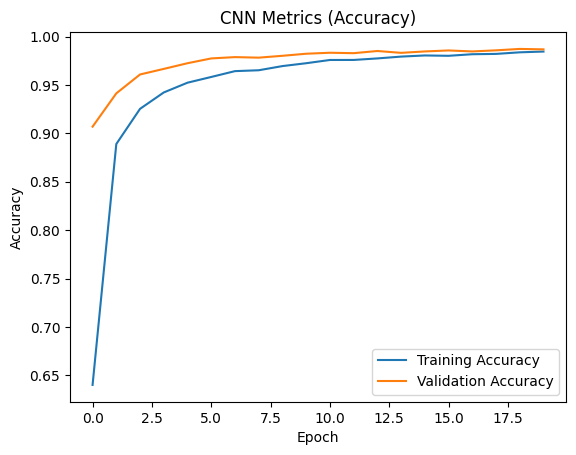

In [17]:
# Plot training and validation accuracy diagram
plt.plot(result.history['accuracy'], label='Training Accuracy')
plt.plot(result.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

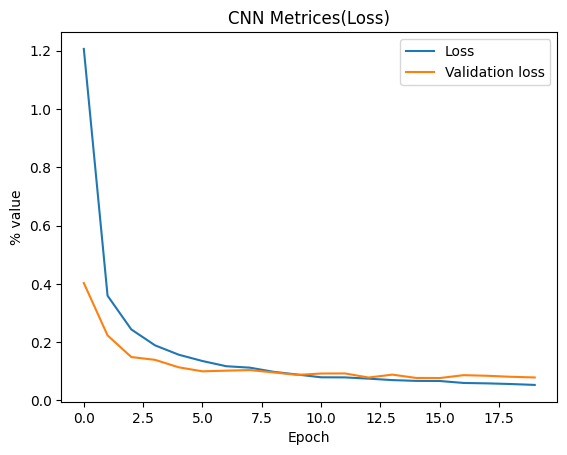

In [18]:
# Plot training and validation loss diagram
plt.plot(result.history['loss'], label='Loss')
plt.plot(result.history['val_loss'], label='Validation loss')
plt.title('CNN Metrices(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

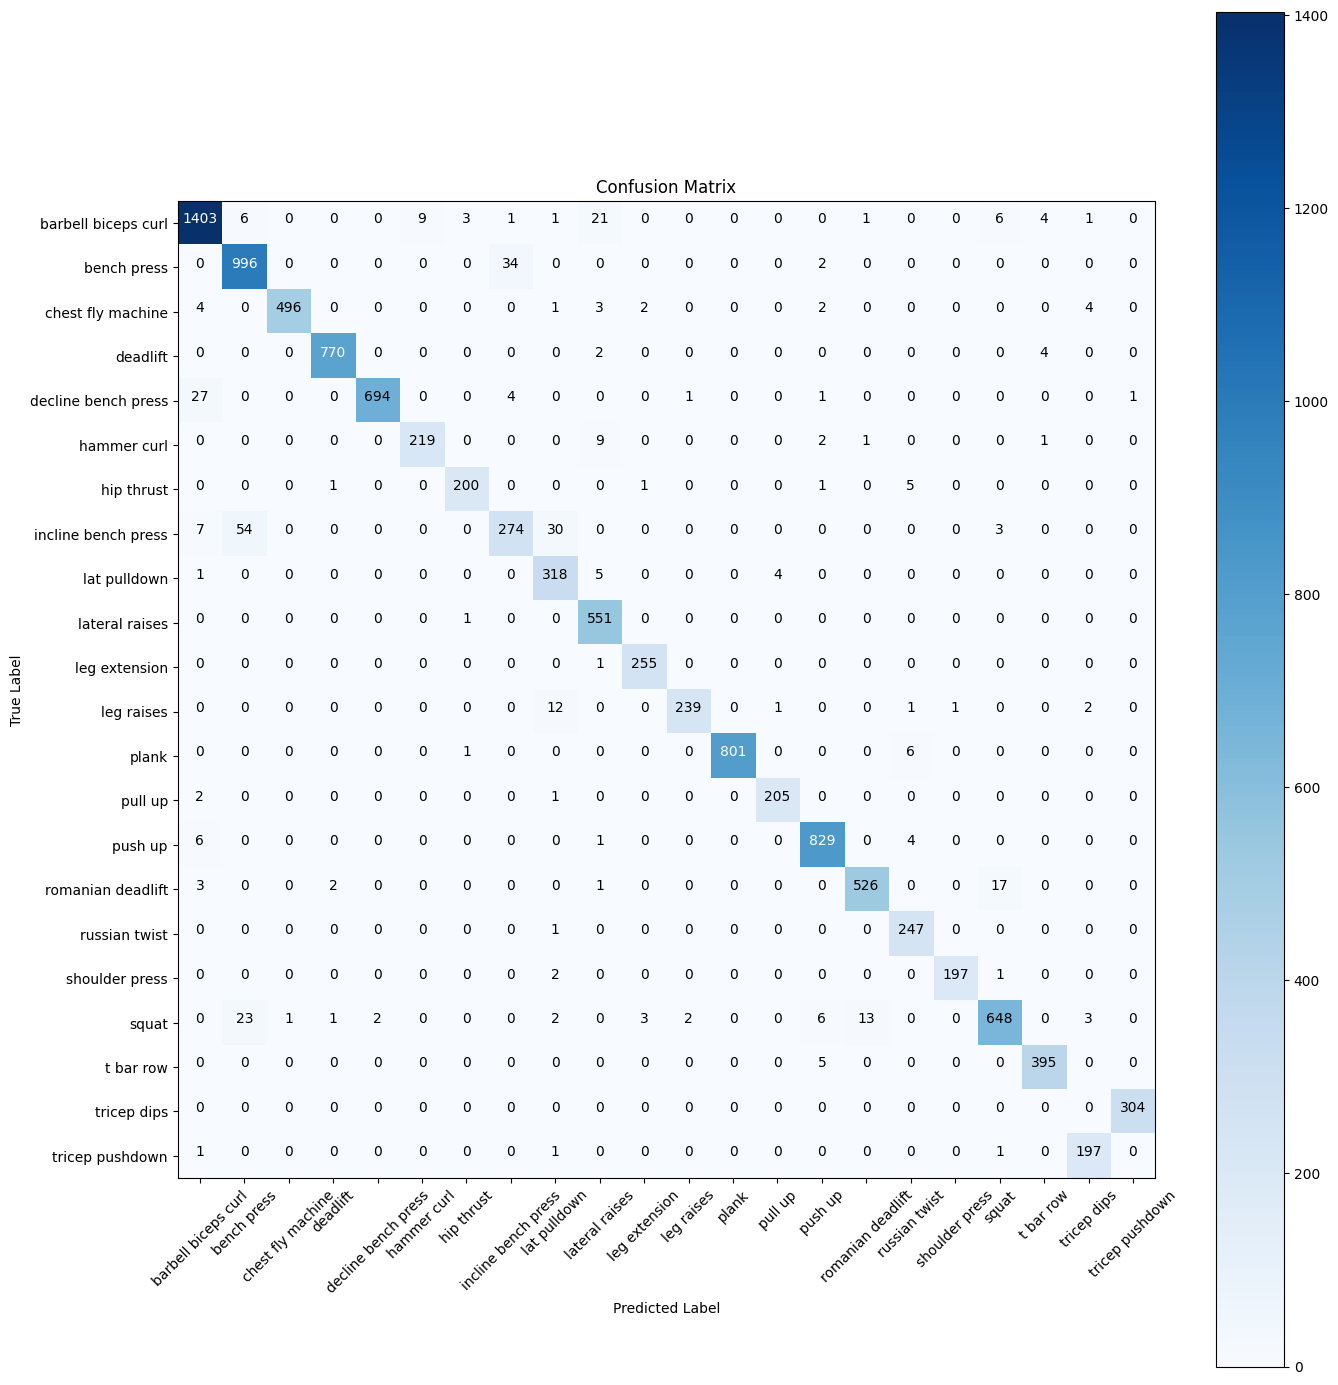

In [28]:
# show confusion_matrix diagram
labels_dic = test_data.class_indices
labels = list(labels_dic.keys())

# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred)

plt.figure(figsize= (14, 14))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation= 45)
plt.yticks(tick_marks, labels)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

In [20]:
def load_image(image_path):

    image = load_img(image_path, target_size=(299, 299), color_mode='rgb')
    image = img_to_array(image)
    image = image / 255.0  # Rescale to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def get_label(integer, labels_dict):

    for label, index in labels_dict.items():
        if index == integer:
            return label
    return None

def predict_workout(model, image_path, labels_dict):

    image=cv2.imread(image_path)
    #resize each image to (224,224)
    image=cv2.resize(image,(224,224))
    #convert each image to array
    image=img_to_array(image)
    #reshape each image 
    image=image.reshape((-1,224,224,3))
    image=preprocess_input(image)
    pred = model.predict(image)
    pred = np.argmax(pred)
    label = get_label(pred, labels_dict)
    return label

def show_image_from_path(image_path):
    img = Image.open(image_path)
    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 332ms/step
Predicted emotion: barbell biceps curl


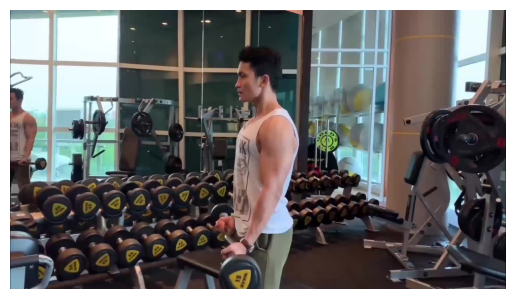

In [27]:
image_file_path = "ezgif-frame-001(11).jpg"
labels = val_data.class_indices
predicted_emotion = predict_workout(model, image_file_path, labels)
print(f"Predicted emotion: {predicted_emotion}")
show_image_from_path(image_file_path)

In [22]:
# Save Model
model.save('workout Detection Model')
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('workout Detection Model')
tflite_model = converter.convert()

# Save the tflite model
with open('workout Detection Model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: workout Detection Model\assets


INFO:tensorflow:Assets written to: workout Detection Model\assets
